In [1]:
import os
os.chdir('..')

In [2]:
from models import SM_MNL
from models import SM_Nested
from models import LPMC_MNL_Full
from models import LPMC_MNL_DC
from models import LPMC_MNL_RR
from models import MTMC_MNL
from algos import OptAlg

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

sns.set(font_scale=1.5)

data_folder = '../data/'
figure_folder = '../figures/'

# For the Python notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [74]:
model = LPMC_MNL_DC(data_folder)

In [75]:
types = ['LS', 'TR']
color = {'LS': 'k', 'TR': 'r'}
str_ = {'LS': 'Line search', 'TR': 'Trust-region'}

In [123]:
res = {'LS': {}, 'TR': {}}

for type_ in types:
    ioa = OptAlg(alg_type=type_, direction='hess')
    
    res[type_]['rel_grad'] = {}
    
    # Optimize with good stop crit
    tmp = model.optimize(ioa, **{'stop_crit': 'rel_grad', 'max_epochs': 20, 'thresh': 2e-6, 'thresh_tr': 1e-5})
    
    print("Done {} with good crit".format(type_))
    
    fs = []
    res[type_]['rel_grad']['x'] = np.array(ioa.xs)
    grad = []

    for x in ioa.xs:
        tmp = model.biogeme.calculateLikelihoodAndDerivatives(x)
        fs.append(tmp[0])
        grad.append(tmp[1])

    res[type_]['rel_grad']['f'] = np.array(fs)
    res[type_]['rel_grad']['g'] = np.array(grad)
    
    res[type_]['grad'] = {}
    
    # Optimize with bad stop crit
    tmp = model.optimize(ioa, **{'stop_crit': 'grad', 'max_epochs': 20, 'thresh': 2e-6, 'thresh_tr': 1e-5})
    
    print("Done {} with bad crit".format(type_))
    
    fs = []
    res[type_]['grad']['x'] = np.array(ioa.xs)
    grad = []

    for x in ioa.xs:
        tmp = model.biogeme.calculateLikelihoodAndDerivatives(x)
        fs.append(tmp[0])
        grad.append(tmp[1])

    res[type_]['grad']['f'] = np.array(fs)
    res[type_]['grad']['g'] = np.array(grad)   
    

0.0
0.0470314790962972
0.028587873730817136
0.07046126143233326
0.056906001728524155
0.014757773632910918
0.007642641207353866
0.008444670520876432
0.004295900382895249
0.0024667290468356564
0.001449493337353044
0.0008187196440846171
5.064088700352484e-05
1.0751079870700913e-05
4.623588303683308e-06
8.767729145495406e-07
Done LS with good crit
26795.16490666328
9030.126637321546
3497.389557564092
2037.6700804516372
1049.6888769326458
367.8440336973514
388.0636817936468
119.38717414006852
74.30905035649954
52.60964338646096
22.906107583718935
14.317398099345603
0.6702095410978575
0.17153505211085912
0.07130517634137643
0.014657198791383195
0.0031084904893262377
0.00017770010399278103
3.349529174546629e-06
3.671449422016901e-10
Done LS with bad crit
0.0
0.07018094973852679
0.14454267405708413
0.11366349265201323
0.06059677485415538
0.015520774501683203
0.000962382873066657
3.494774461533409e-06
2.1898508569895638e-10
Done TR with good crit
26795.16490666328
6654.152979763286
3904.5381415

/home/gael/Documents/EPFL/PhD/Article/DCM_Opti/code/algos/types/TrustRegion.py:48: RuntimeWarning: divide by zero encountered in double_scalars
  rho_k = top / bottom


2.410073058335837e-06
1.7439307960366503e-06
Done TR with bad crit


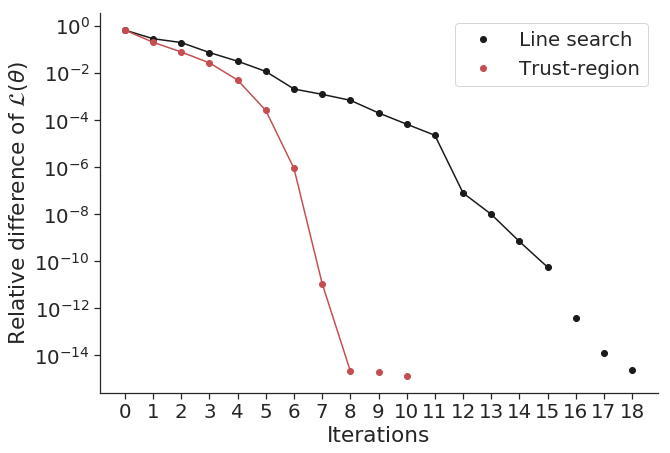

In [128]:
# Do stuff with the log likelihood

plt.figure(figsize=(10, 7), frameon=False)

sns.set_context("paper")
sns.set(font_scale = 1.8)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})

ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

max_len = 0

for type_ in types:
    tmp = res[type_]
    
    max_ = tmp['grad']['f'][-1]
    
    delta_grad = np.abs(tmp['grad']['f'] - max_)/np.abs(max_)
    delta_rel_grad = np.abs(tmp['rel_grad']['f'] - max_)/np.abs(max_)
    
    plt.semilogy(delta_grad[:-1], 'o', color=color[type_], label=str_[type_])
    plt.semilogy(delta_rel_grad, '-', color=color[type_])
    
    max_len = len(delta_grad[:-1]) if len(delta_grad[:-1]) > max_len else max_len
    
plt.xticks(list(range(max_len)))

plt.xlabel('Iterations')
plt.ylabel('Relative difference of $\mathcal{L}(\\theta)$')

plt.legend()

plt.savefig(figure_folder + 'png/rel_diff_log_like.png', bbox_inches='tight')
plt.savefig(figure_folder + 'pdf/rel_diff_log_like.pdf', bbox_inches='tight')

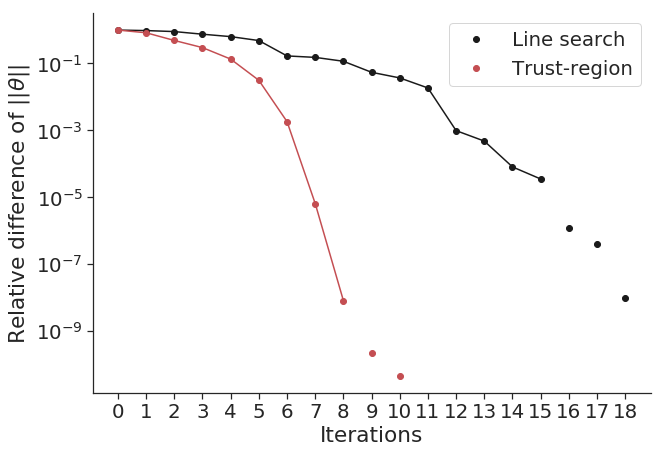

In [129]:
# Do stuff with the norm of the parameters

plt.figure(figsize=(10, 7), frameon=False)

sns.set_context("paper")
sns.set(font_scale = 1.8)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})

ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

max_len = 0

for type_ in types:
    tmp = res[type_]
    
    max_ = tmp['grad']['x'][-1]
        
    delta_grad = np.abs(tmp['grad']['x'] - max_)
    delta_grad = np.linalg.norm(delta_grad, axis=1)/np.linalg.norm(max_)

    delta_rel_grad = np.abs(tmp['rel_grad']['x'] - max_)
    delta_rel_grad = np.linalg.norm(delta_rel_grad, axis=1)/np.linalg.norm(max_)
    
    plt.semilogy(delta_grad[:-1], 'o', color=color[type_], label=str_[type_])
    plt.semilogy(delta_rel_grad, '-', color=color[type_])
    
    max_len = len(delta_grad[:-1]) if len(delta_grad[:-1]) > max_len else max_len
    
plt.xticks(list(range(max_len)))

plt.xlabel('Iterations')
plt.ylabel('Relative difference of $||\\theta||$')

plt.legend()

plt.savefig(figure_folder + 'png/rel_diff_params.png', bbox_inches='tight')
plt.savefig(figure_folder + 'pdf/rel_diff_params.pdf', bbox_inches='tight')

In [130]:
def sc_rel_grad(xs, f, grad):

    vals = [np.abs(x*df) for x, df in zip(xs, grad)]

    return np.max(vals)/np.abs(f)

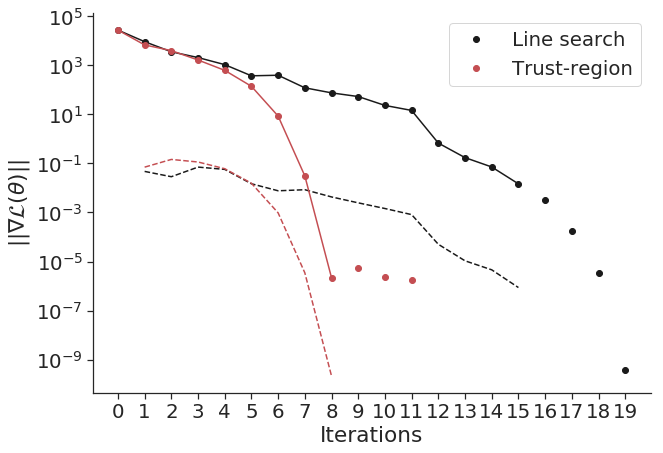

In [131]:
# Do stuff with the norm of the parameters

plt.figure(figsize=(10, 7), frameon=False)

sns.set_context("paper")
sns.set(font_scale = 1.8)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})

ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

max_len = 0

for type_ in types:
    tmp = res[type_]
            
    delta_grad = np.linalg.norm(tmp['grad']['g'], axis=1)
    delta_rel_grad = np.linalg.norm(tmp['rel_grad']['g'], axis=1)
    
    sc_rel_grad_arr = []

    for x, f, g in zip(tmp['rel_grad']['x'], tmp['rel_grad']['f'], tmp['rel_grad']['g']):

        sc_rel_grad_arr.append(sc_rel_grad(x, f, g))
    
    plt.semilogy(delta_grad, 'o', color=color[type_], label=str_[type_])
    plt.semilogy(delta_rel_grad, '-', color=color[type_])
    plt.semilogy(range(1, len(sc_rel_grad_arr)), sc_rel_grad_arr[1:], '--', color=color[type_])

    
    max_len = len(delta_grad) if len(delta_grad) > max_len else max_len
    
plt.xticks(list(range(max_len)))

plt.xlabel('Iterations')
plt.ylabel('$||\\nabla\mathcal{L}(\\theta)||$')

plt.legend()

plt.savefig(figure_folder + 'png/grad_and_rel_grad.png', bbox_inches='tight')
plt.savefig(figure_folder + 'pdf/grad_and_rel_grad.pdf', bbox_inches='tight')